Import

In [33]:
# IMPORT PACKAGES
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcvs.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

Load simulation data

In [43]:
from mlcvs.utils.io import create_dataset_from_files
from mlcvs.data import DictionaryDataModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load data into dataset
dataset, df = create_dataset_from_files(filenames,filter_args={'regex':'p.x|p.y'},return_dataframe=True)

# create datamodule
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 11)

 - Loaded dataframe (5001, 11): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2']
 - Descriptors (5001, 2): ['p.x', 'p.y']


Define model

In [44]:
from mlcvs.cvs import AutoEncoder_CV

n_components = 1
encoder_layers = [2,10,10,n_components]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = AutoEncoder_CV (encoder_layers, options=options )
model

AutoEncoder_CV(
  (normIn): Normalization(in_features=2, out_features=2, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

Define Trainer & Datamodule --> Fit

In [45]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=10)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | normIn  | Normalization | 0      | [2]      | [2]      
1 | encoder | FeedForward   | 151    | [2]      | [1]      
2 | decoder | FeedForward   | 152    | ?        | ?        
-----------------------------------------------------------------
303       Trainable params
0         Non-trainable params
303       Total params
0.001     Total estimated model params size (MB)


Epoch 141: 100%|██████████| 2/2 [00:00<00:00, 195.95it/s, loss=0.0285]      


View learning curves

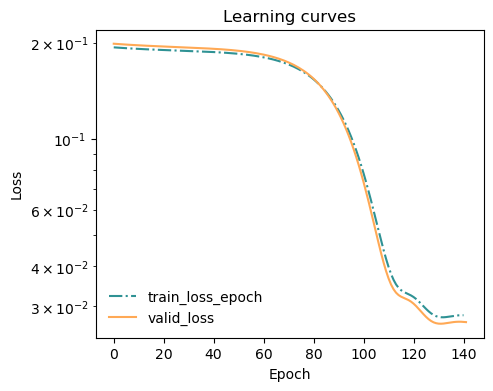

In [48]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='log')


Normalize output after training

In [49]:
from mlcvs.core.transform import Normalization
from mlcvs.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

Isolines CV

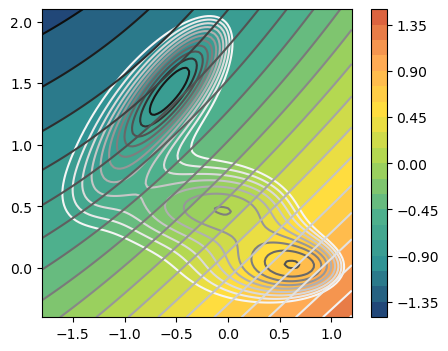

In [50]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,vmax=24,mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

CV histogram

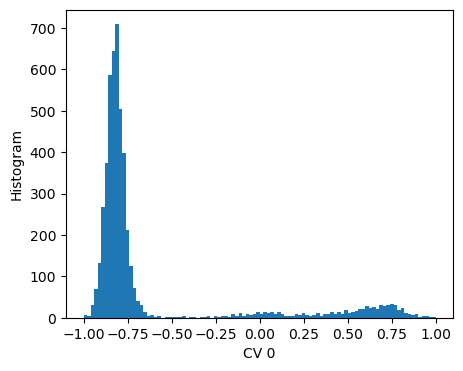

In [51]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

FES 

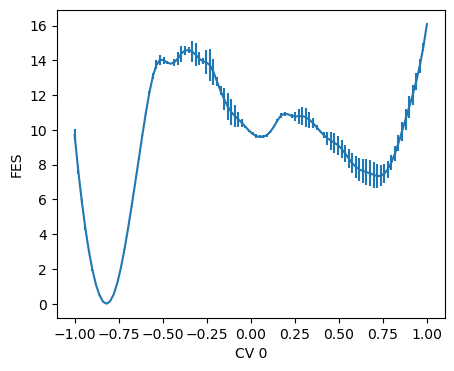

In [52]:
from mlcvs.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    fes,grid,bounds,std = compute_fes(s[:,i], kbt=2.5, plot=True, scale_by='range', bandwidth=0.02, blocks=2, plot_max_fes=20, ax=ax )
    ax.set_xlabel(f'CV {i}')